# Data loading

Functions import

In [7]:
import shutil
import random
import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import pathlib

import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
#from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Set random seed for reproducibility
seed_train_validation = 42
tf.random.set_seed(seed_train_validation)
np.random.seed(seed_train_validation)

Dataset loading

In [8]:
# Directory paths
train_data_dir = '/kaggle/input/aml-flowers-dataset/train_images_by_class/train_images_by_class'
val_data_dir = '/kaggle/input/aml-flowers-dataset/validation_images_by_class/validation_images_by_class'
test_data_dir = '/kaggle/input/aml-flowers-dataset/test_images_by_class/test_images_by_class'

# CSV file paths
train_csv_path = '/kaggle/input/aml-flowers-dataset/classes_train.csv'
val_csv_path = '/kaggle/input/aml-flowers-dataset/classes_valid.csv'
test_csv_path = '/kaggle/input/aml-flowers-dataset/classes_test.csv'

train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

# Data elaboration

Preprocessing and data augmentation on train set

In [9]:
# Image size
image_size = (224, 224)

# Batch size
batch_size = 64

# Data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    brightness_range=[1-0.3, 1+0.3],
    zoom_range=[1-0.2, 1+0.2],
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed = 42
)

Found 1020 images belonging to 102 classes.


Preprocessing of test set and validation set

In [10]:
# Validation and test data generators without data augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 1020 images belonging to 102 classes.
Found 6149 images belonging to 102 classes.


Learning rate finder funcion

In [11]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9, 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier

    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0


    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')

        if self.iteration!=0:
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss:
            self.best_loss = loss

        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)

        self.losses.append(loss)
        self.iteration += 1
        if loss > self.best_loss*self.stop_multiplier:
            self.model.stop_training = True

    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

VGG16 import, model cutting, layer freezing and building the model classifier

In [12]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#base_model.summary()

#layer chosen for the base model cutting
cut_off_layer = 'block5_conv2'

model_cut = Model(inputs=base_model.input, outputs=base_model.get_layer(cut_off_layer).output)

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Building the model
model = tf.keras.Sequential([
    model_cut,
    GlobalAveragePooling2D(),
    Dense(1024),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.5),
    Dense(102, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 14, 14, 512)       12354880  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

Linear learning rate scheduler for the definition of the optimal range of values on which the CLR works.

In [13]:
import keras

class LinearLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, start_lr, end_lr, num_epochs):
        super(LinearLearningRateScheduler, self).__init__()
        self.start_lr = start_lr  
        self.end_lr = end_lr      
        self.num_epochs = num_epochs  
        self.lr_increment = (end_lr - start_lr) / (num_epochs - 1)  
        self.learning_rates = []  
        self.losses = []  

    def on_epoch_end(self, epoch, logs=None):
        
        new_lr = self.start_lr + (epoch * self.lr_increment)

        keras.backend.set_value(self.model.optimizer.lr, new_lr)

        self.learning_rates.append(new_lr)
        self.losses.append(logs.get('loss'))

        print(f"\nEpoch {epoch+1}: Learning rate is {new_lr:.6f}, Loss is {logs.get('loss')}.")


In [14]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

start_lr = 10e-9
end_lr = 1
num_epochs = 20

linearLR = LinearLearningRateScheduler(start_lr, end_lr, num_epochs)

Learning rate choice

In [16]:
history_linearLR = model.fit(train_generator, epochs = num_epochs, callbacks=[linearLR])

Epoch 1/20


I0000 00:00:1706813522.446784     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - ETA: 0s - loss: 5.4091 - accuracy: 0.0069
Epoch 1: Learning rate is 0.000000, Loss is 5.409144401550293.
16/16 [==============================] - 54s 2s/step - loss: 5.4091 - accuracy: 0.0069
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 5.0394 - accuracy: 0.0137
Epoch 2: Learning rate is 0.052632, Loss is 5.0393548011779785.
16/16 [==============================] - 16s 961ms/step - loss: 5.0394 - accuracy: 0.0137
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 4.4175 - accuracy: 0.0716
Epoch 3: Learning rate is 0.105263, Loss is 4.417534351348877.
16/16 [==============================] - 16s 961ms/step - loss: 4.4175 - accuracy: 0.0716
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 3.0814 - accuracy: 0.2667
Epoch 4: Learning rate is 0.157895, Loss is 3.081362724304199.
16/16 [==============================] - 16s 1s/step - loss: 3.0814 - accuracy: 0.2667
Epoch 5/20
16/16 [==========

Graph representing how the accuracy varies ad the varying of the learning rate.

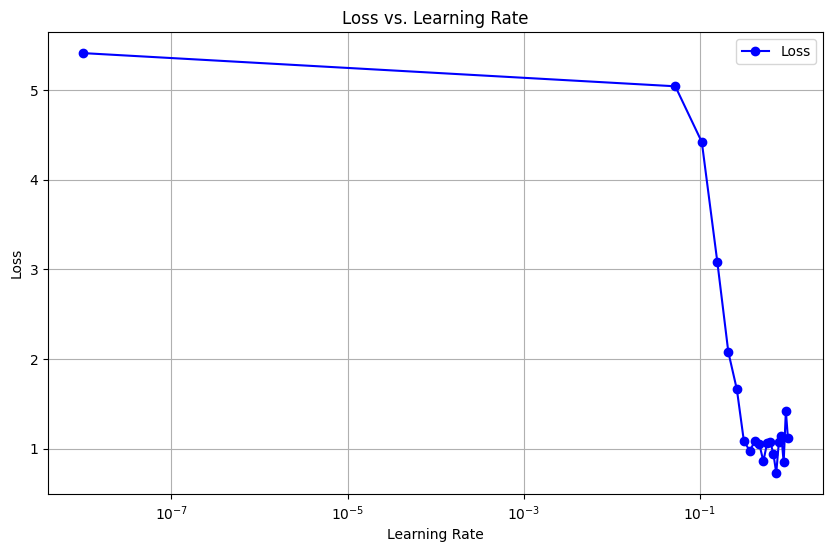

In [17]:
def plot_lr_vs_loss(learning_rates, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, losses, marker='o', color='b', label='Loss')
    plt.title('Loss vs. Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()

plot_lr_vs_loss(linearLR.learning_rates, linearLR.losses)

# Compiling and training of the model

Firstly, the model is trained with all the weights frozen

CyclicLearningRate (CLR) parameters definition:

* the values are set as base_lr=0.052632 and max_lr=0.368421 and these values are taken from the graph computed beforhand
* the step size has been chosen empirically
* the chosen method is trianguale because it keeps the base_lr and the max_lr constant 


In order to reduce overfitting an early stopping function with patience five is implemented

In [18]:
# Optimizer
opt = keras.optimizers.SGD(weight_decay=0.004)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

clr = CyclicLR(base_lr=0.052632, max_lr=0.368421, step_size=16, mode='triangular2')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit_generator(
    train_generator,
    epochs=80,
    verbose=1,
    validation_data=val_generator,
    callbacks=[clr, early_stopping]
)

/tmp/ipykernel_34/1818099893.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80
16/16 [==============================] - 29s 2s/step - loss: 0.6029 - accuracy: 0.8745 - val_loss: 1.7234 - val_accuracy: 0.6912
Epoch 2/80
16/16 [==============================] - 21s 1s/step - loss: 0.2658 - accuracy: 0.9314 - val_loss: 1.1175 - val_accuracy: 0.7686
Epoch 3/80
16/16 [==============================] - 22s 1s/step - loss: 0.1869 - accuracy: 0.9598 - val_loss: 0.9586 - val_accuracy: 0.7804
Epoch 4/80
16/16 [==============================] - 22s 1s/step - loss: 0.1495 - accuracy: 0.9725 - val_loss: 0.8544 - val_accuracy: 0.8059
Epoch 5/80
16/16 [==============================] - 22s 1s/step - loss: 0.1634 - accuracy: 0.9637 - val_loss: 0.8081 - val_accuracy: 0.8069
Epoch 6/80
16/16 [==============================] - 22s 1s/step - loss: 0.1355 - accuracy: 0.9735 - val_loss: 0.7798 - val_accuracy: 0.8147
Epoch 7/80
16/16 [==============================] - 22s 1s/step - loss: 0.1332 - accuracy: 0.9745 - val_loss: 0.7458 - val_accuracy: 0.8157
Epoch 8/80
16/16 [==

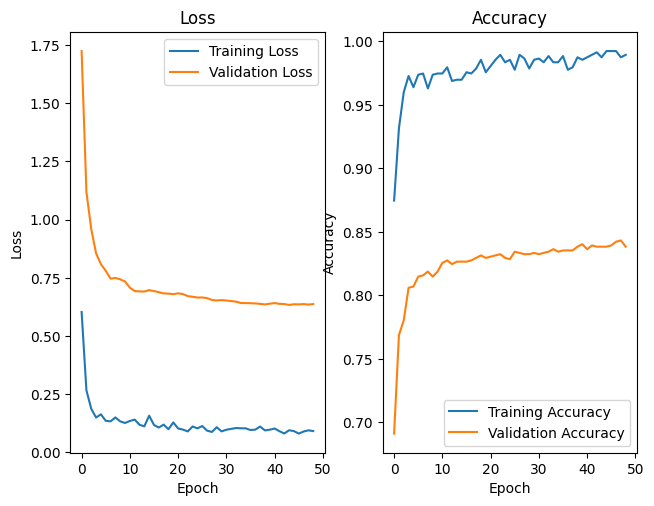

In [19]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Training Loss')
  ax[0].plot(valid_loss, label='Validation Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc, label='Training Accuracy')
  ax[1].plot(valid_acc, label='Validation Accuracy')
  ax[1].legend()

  plt.show()

plot_performance(history)

In [20]:
# Evaluate on the test set
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

97/97 [==============================] - 68s 703ms/step - loss: 0.7686 - accuracy: 0.8037
Test loss: 0.7686445713043213
Test accuracy: 0.8037078976631165


In [21]:
# Saving the model for time saving purposes
#model.save('vgg16_freezed.keras')

Unfreezing of the last five layers, compiling and training

In [22]:
def unfreeze_layers(layers_to_unfreeze, base_model):
    
    num_conv_layers_to_unfreeze = layers_to_unfreeze

    unfrozen_conv_layers = 0

    for layer in reversed(base_model.layers):

        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Activation):

            layer.trainable = True

            unfrozen_conv_layers += 1

            if unfrozen_conv_layers >= num_conv_layers_to_unfreeze:
                break

    for layer in base_model.layers:
        print(layer, layer.trainable)

unfreeze_layers(5, model_cut)

<keras.src.engine.input_layer.InputLayer object at 0x7830fe81e6e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830fe81f2e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830fe8350c0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7830fcd3d750> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830fe8341f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830fcd3ce80> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7831a81511b0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7831a8150220> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830fcd3ca00> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830fcd3f760> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7830ec2d6110> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7830ec2d5ed0> True
<keras.src.layers.convolutional.conv2d.Conv2D obj

In [23]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(weight_decay=0.004, lr=1e-9), metrics=['accuracy'])

# Train the model
history = model.fit_generator(
    train_generator,
    epochs=80,
    verbose=1,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/tmp/ipykernel_34/1393972361.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80
16/16 [==============================] - 34s 2s/step - loss: 0.0783 - accuracy: 0.9931 - val_loss: 0.7714 - val_accuracy: 0.7990
Epoch 2/80
16/16 [==============================] - 22s 1s/step - loss: 0.0822 - accuracy: 0.9902 - val_loss: 0.6832 - val_accuracy: 0.8196
Epoch 3/80
16/16 [==============================] - 22s 1s/step - loss: 0.0657 - accuracy: 0.9902 - val_loss: 0.6639 - val_accuracy: 0.8324
Epoch 4/80
16/16 [==============================] - 22s 1s/step - loss: 0.0577 - accuracy: 0.9922 - val_loss: 0.7673 - val_accuracy: 0.8078
Epoch 5/80
16/16 [==============================] - 22s 1s/step - loss: 0.0565 - accuracy: 0.9941 - val_loss: 0.7166 - val_accuracy: 0.8275
Epoch 6/80
16/16 [==============================] - 22s 1s/step - loss: 0.0577 - accuracy: 0.9951 - val_loss: 0.7383 - val_accuracy: 0.8225
Epoch 7/80
16/16 [==============================] - 22s 1s/step - loss: 0.0541 - accuracy: 0.9961 - val_loss: 0.6643 - val_accuracy: 0.8353
Epoch 8/80
16/16 [==

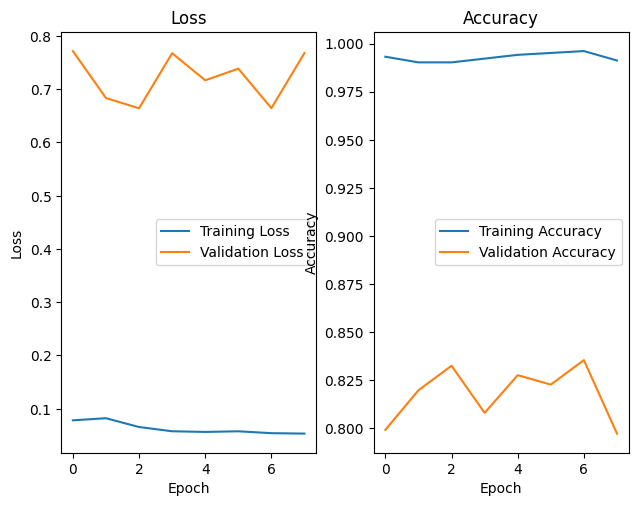

In [24]:
plot_performance(history)

In [35]:
# Evaluate on the test set
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

97/97 [==============================] - 34s 347ms/step - loss: 0.6731 - accuracy: 0.8291
Test loss: 0.6731006503105164
Test accuracy: 0.8290778994560242


In [36]:
# Saving the model for time saving purposes
#model.save('vgg16_unfreezed.keras')

# Results visualization

97/97 [==============================] - 32s 332ms/step


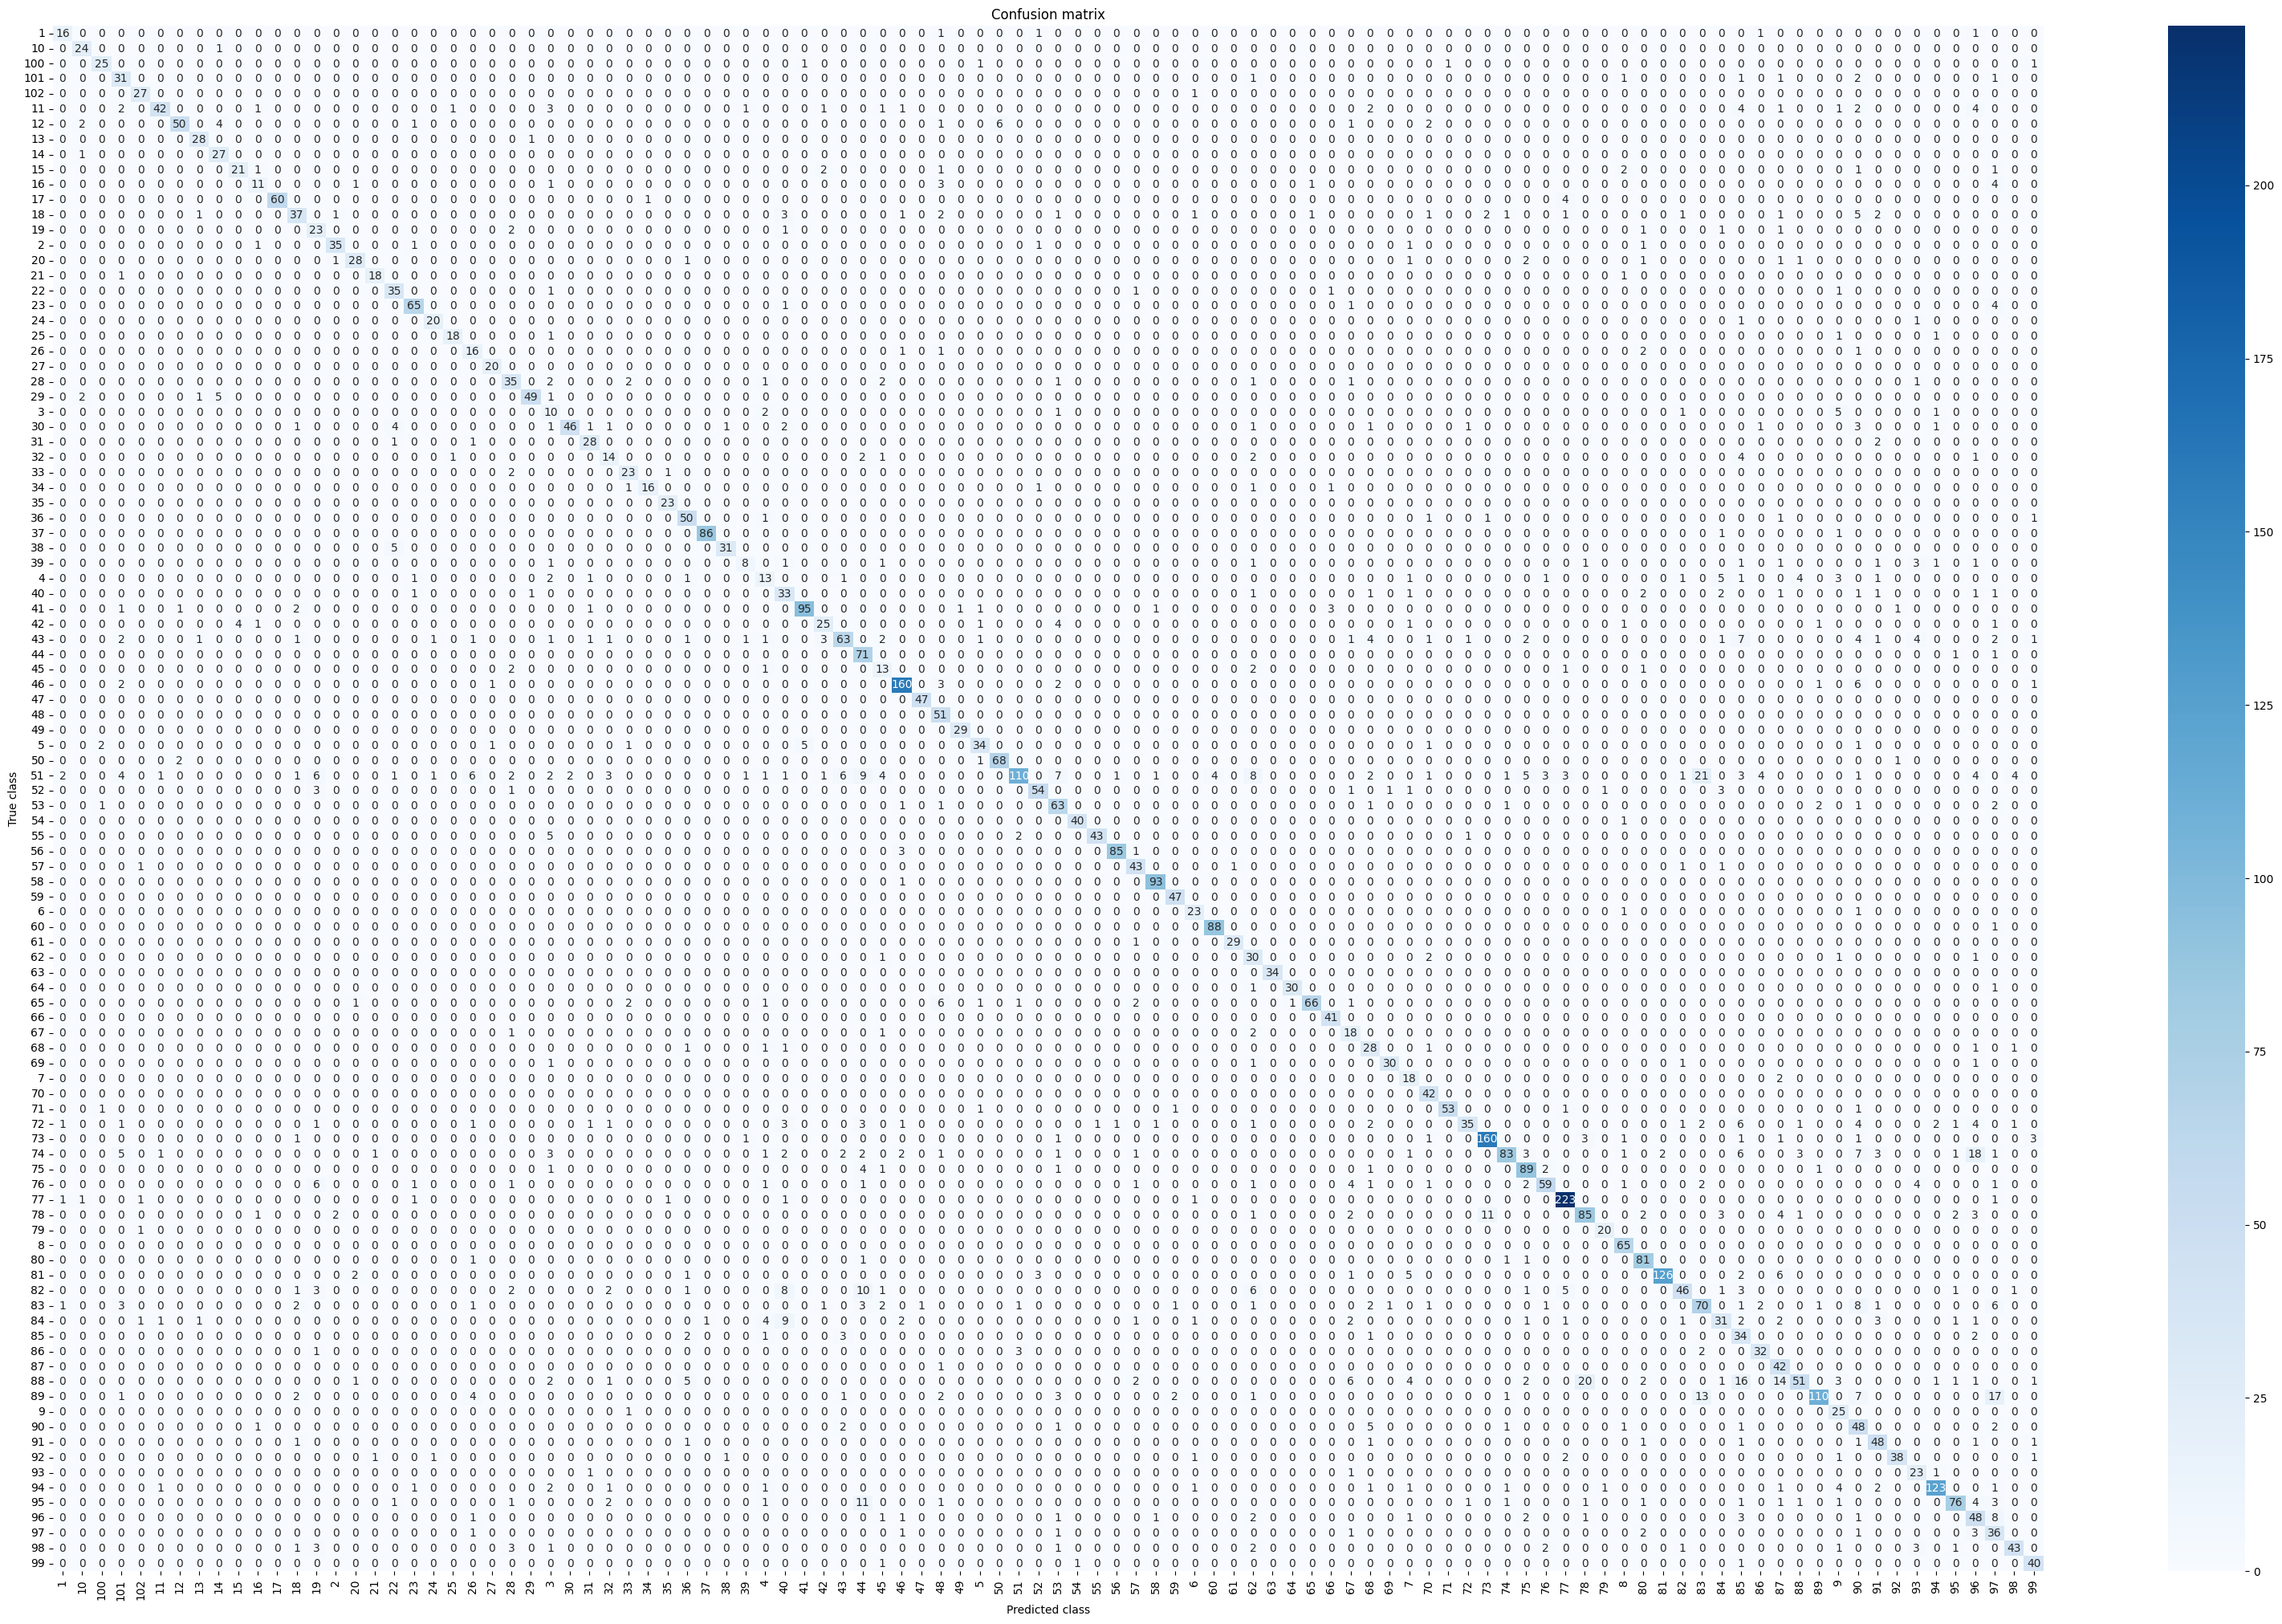

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get model predictiokn on test dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Get confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(40, 25))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')

class_names = sorted(test_generator.class_indices, key=test_generator.class_indices.get)

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

plt.xticks(ticks=np.arange(0.5, 102.5), labels=class_names)
plt.yticks(ticks=np.arange(0.5, 102.5), labels=class_names)

plt.savefig('confusion_matrix.png')

plt.show()

In [28]:
from sklearn.metrics import classification_report

# Get model predictions on test dataset
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))

97/97 [==============================] - 33s 342ms/step
              precision    recall  f1-score   support

           1       0.76      0.80      0.78        20
          10       0.80      0.96      0.87        25
         100       0.86      0.86      0.86        29
         101       0.58      0.82      0.68        38
         102       0.87      0.96      0.92        28
          11       0.91      0.63      0.74        67
          12       0.94      0.75      0.83        67
          13       0.88      0.97      0.92        29
          14       0.73      0.96      0.83        28
          15       0.84      0.72      0.78        29
          16       0.65      0.52      0.58        21
          17       1.00      0.92      0.96        65
          18       0.74      0.60      0.66        62
          19       0.50      0.79      0.61        29
           2       0.90      0.88      0.89        40
          20       0.85      0.78      0.81        36
          21       0.90  